# ДЗ 4

Дописать свой метод predict внутри нейронной сети.

Протестировать на новых данных, которых не было в обучении.

In [1]:
import numpy as np

In [2]:
def sigmoid(x):
    """
    f(x) = 1 / (1 + e^(-x))
    """
    return 1 / (1 + np.exp(-x))


def derivSigmoid(x):
    """
    Производная сигмоиды:\n
    f'(x) = f(x) * (1 - f(x))
    """
    fx = sigmoid(x)
    return fx * (1 - fx)

In [25]:
LEARN_RATE = 0.05
EPOCHS_NUM = 50
LOG_INTERVAL = 1

In [4]:
class Neuron:
    def __init__(self, inputsNum):
        self.activeFunc = sigmoid
        self.derivFunc = derivSigmoid
        
        self.weights = np.array([
            np.random.normal()
            for _ in range(inputsNum)
        ])
        self.bias = np.random.normal()

    @property
    def total(self):
        """
        Сумма произведений входов на веса + порог
        """
        return np.dot(self.weights, self.x) + self.bias
    
    def feedForward(self, x):
        """
        Расчёт выхода
        """
        self.x = x
        return self.activeFunc(self.total)
    
    @property
    def dh_dw_list(self):
        """
        Производная выхода нейрона от вх. весов
        """
        return np.hstack([self.x, [1]]) * self.derivFunc(self.total)
    
    @property
    def dYp_dh_list(self):
        """
        Производная выхода сети от выходов предш. нейронов
        """
        return self.weights * self.derivFunc(self.total)

In [26]:
class OurNeuralNetwork:
    def __init__(self):
        self.h1 = Neuron(2)
        self.h2 = Neuron(2)
        self.o1 = Neuron(2)

    def feedForward(self, x):
        h1_o = self.h1.feedForward(x)
        h2_o = self.h2.feedForward(x)
        o1 = self.o1.feedForward([h1_o, h2_o])

        return o1

    def train(self, trainData, trueVals):
        metrics = [] # для сохранения значений ошибок

        for epoch in range(EPOCHS_NUM):
            for x, y_t in zip(trainData, trueVals):
                y_p = self.feedForward(x)
                dL_dYp = -2 * (y_t - y_p)
                dYp_dh = self.o1.dYp_dh_list
                
                h1_corr = self.h1.dh_dw_list * dYp_dh[0] * dL_dYp * LEARN_RATE
                self.h1.weights -= h1_corr[:-1]
                self.h1.bias -= h1_corr[-1]

                h2_corr = self.h2.dh_dw_list * dYp_dh[1] * dL_dYp * LEARN_RATE
                self.h2.weights -= h2_corr[:-1]
                self.h2.bias -= h2_corr[-1]
                
                o1_corr = self.o1.dh_dw_list * dL_dYp * LEARN_RATE
                self.o1.weights -= o1_corr[:-1]
                self.o1.bias -= o1_corr[-1]

            if epoch % LOG_INTERVAL == 0:
                y_p_List = np.apply_along_axis(self.feedForward, 1, trainData)
                metrics.append(((trueVals - y_p_List) ** 2).mean())
        
        return metrics

In [27]:
def shiftData():
    meanVals = []
    def inner(data, train = False):
        nonlocal meanVals
        if train:
            meanVals = list(map(np.mean, zip(*data)))
        for a in data:
            for i, x in enumerate(a):
                a[i] = x - meanVals[i]
    return inner

shiftData = shiftData()

In [14]:
# Определим набор данных
trainData = [
    np.array([54.4, 165.1]),  # Алиса
    np.array([65.44, 183]),   # Боб
    np.array([62.2, 178]),   # Чарли
    np.array([49, 152]),  # Диана
]
shiftData(trainData, train=True)

y_t = np.array([
    0,  # Алиса
    1,  # Боб
    1,  # Чарли
    0,  # Диана
])

In [30]:
import csv

def loadCSV(fileName):
    with open(fileName, encoding="utf-8") as inFile:
        csvReader = csv.DictReader(inFile)
        data = []
        yList = []
        for itemDict in csvReader:
            data.append([float(itemDict['Height']), float(itemDict['Weight'])])
            yList.append(1 if itemDict['Gender'] == "Male" else 0)
        
        return data, yList
    
trainData, y_t = loadCSV(".\\weight-height1.csv")
shiftData(trainData, train=True)

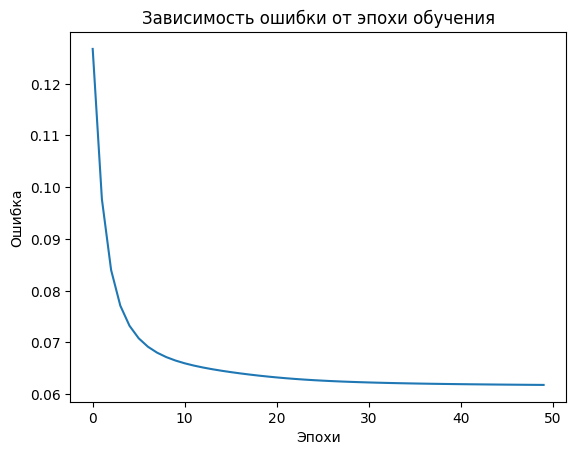

In [35]:
import matplotlib.pyplot as plt

network = OurNeuralNetwork()
metrics = network.train(trainData, y_t)

plt.plot(range(0, EPOCHS_NUM, LOG_INTERVAL), metrics)
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.title("Зависимость ошибки от эпохи обучения")
plt.show()

In [39]:
testData = [
    np.array([75, 179]),  # Михаил
    np.array([54.7, 165]), # Анна
    np.array([103.4, 182]), # Василий
    np.array([83.7, 185]),  # Андрей
    np.array([67, 158]),  # Дарья
    np.array([62, 177]),  # Арсений
    np.array([54.4, 165.1]),  # Алиса
    np.array([65.44, 183]),   # Боб
    np.array([62.2, 178]),   # Чарли
    np.array([49, 152]),  # Диана
]

y_tt = np.array([
    1,  # Михаил
    0,  # Анна
    1,  # Василий
    1,  # Андрей
    0,  # Дарья
    1,  # Арсений
    0,  # Алиса
    1,  # Боб
    1,  # Чарли
    0,  # Диана
])

shiftData(testData)

for i, x in enumerate(testData):
    print(f"{network.feedForward(x) :.3f}{y_tt[i] :>4}")


0.922   1
0.486   0
0.922   1
0.922   1
0.069   0
0.922   1
0.486   0
0.922   1
0.922   1
0.057   0
